In [15]:
import kagglehub
import pandas as pd
import os
import numpy as np
from pathlib import Path
from pyspark.sql import DataFrame
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import plot_importance
import shap
from Utils.path_file_loader import target_path
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import optuna


sns.set(style="white")


In [2]:
df = pd.read_csv(target_path("DataBase\Cleaned_data.csv"), encoding="utf-8")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# One hot encoder

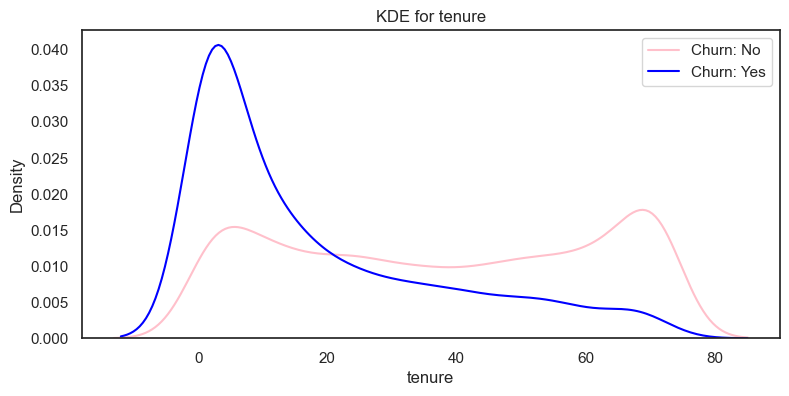

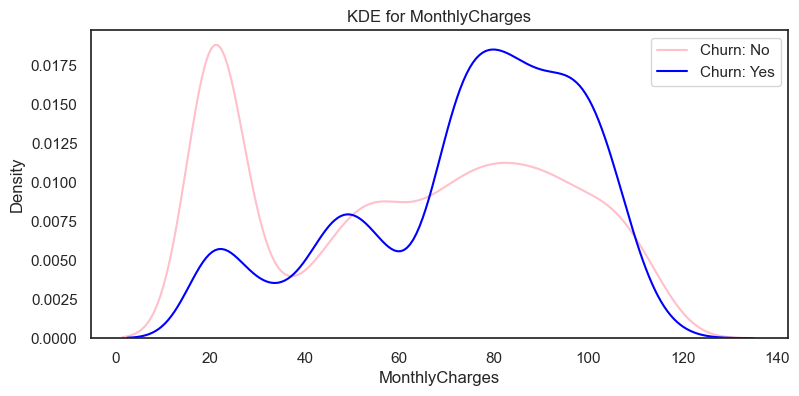

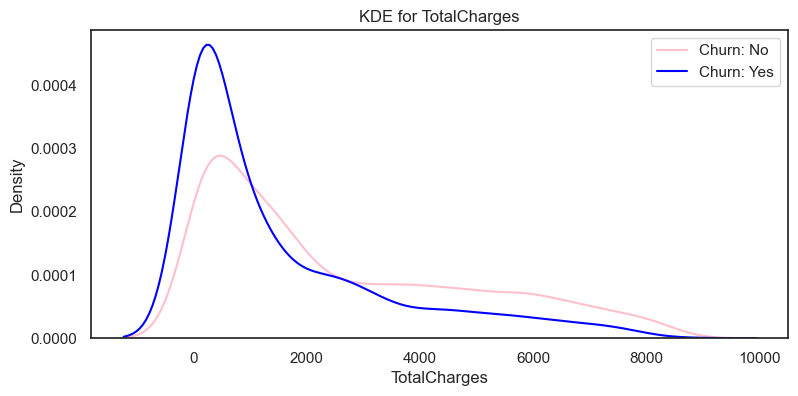

In [3]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['Churn'] == 'No'][feature].dropna(), color= 'pink', label= 'Churn: No')
    ax1 = sns.kdeplot(df[df['Churn'] == 'Yes'][feature].dropna(), color= 'blue', label= 'Churn: Yes')
    plt.legend()
kdeplot('tenure')
kdeplot('MonthlyCharges')
kdeplot('TotalCharges')

In [3]:
encoder = OneHotEncoder(sparse_output=False, drop=None)
encoder_list = ["gender",
                "Partner",
                "Dependents",
                "PhoneService",
                "MultipleLines",
                "InternetService",
                "OnlineSecurity",
                "OnlineBackup",
                "DeviceProtection",
                "TechSupport",
                "StreamingTV",
                "StreamingMovies",
                "Contract",
                "PaperlessBilling",
                "PaymentMethod",
                ]
encoded = encoder.fit_transform(df[encoder_list])

df_encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(encoder_list))
df_final = pd.concat([df.drop(encoder_list, axis=1), df_encoded], axis=1)

print(df_final)

      customerID  SeniorCitizen  tenure  MonthlyCharges  TotalCharges Churn  \
0     7590-VHVEG              0       1           29.85         29.85    No   
1     5575-GNVDE              0      34           56.95       1889.50    No   
2     3668-QPYBK              0       2           53.85        108.15   Yes   
3     7795-CFOCW              0      45           42.30       1840.75    No   
4     9237-HQITU              0       2           70.70        151.65   Yes   
...          ...            ...     ...             ...           ...   ...   
7038  6840-RESVB              0      24           84.80       1990.50    No   
7039  2234-XADUH              0      72          103.20       7362.90    No   
7040  4801-JZAZL              0      11           29.60        346.45    No   
7041  8361-LTMKD              1       4           74.40        306.60   Yes   
7042  3186-AJIEK              0      66          105.65       6844.50    No   

      gender_Female  gender_Male  Partner_No  Partn

# inspect the density of information

# Corr matrix

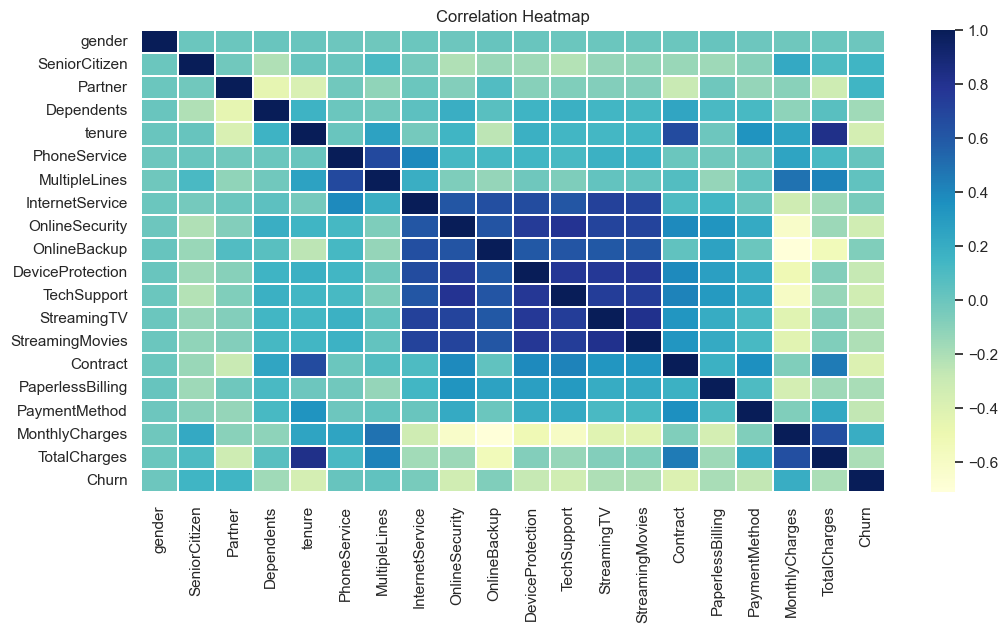

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cor_df = df.drop(['customerID'], axis=1)

cor_df = cor_df.apply(lambda x: pd.factorize(x)[0] if x.dtype == 'object' else x)

corr = cor_df.corr()

plt.figure(figsize=(12, 6))
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=0.2, cmap="YlGnBu")
plt.title("Correlation Heatmap")
plt.show()


In [5]:
encoders = {}

for col in df.columns:
    if df[col].dtype == "object":
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        encoders[col] = le


In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5375,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,3962,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
2,2564,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,1
3,5535,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
4,6511,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1


# No One-hot auto encoder and no Standard scaler

In [7]:
X = df.drop(columns=['customerID', 'Churn']) 
y = df["Churn"]                

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
)

In [8]:
model = LogisticRegression(random_state=42).fit(X_train, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

Logistic regression: training set acc: 0.7962371317003905, test set 0.8105039034776437


c:\Users\korph\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)
print(f"XGBoost : training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

XGBoost : training set acc: 0.8182463613773517, test set 0.8126330731014905


c:\Users\korph\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:11:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


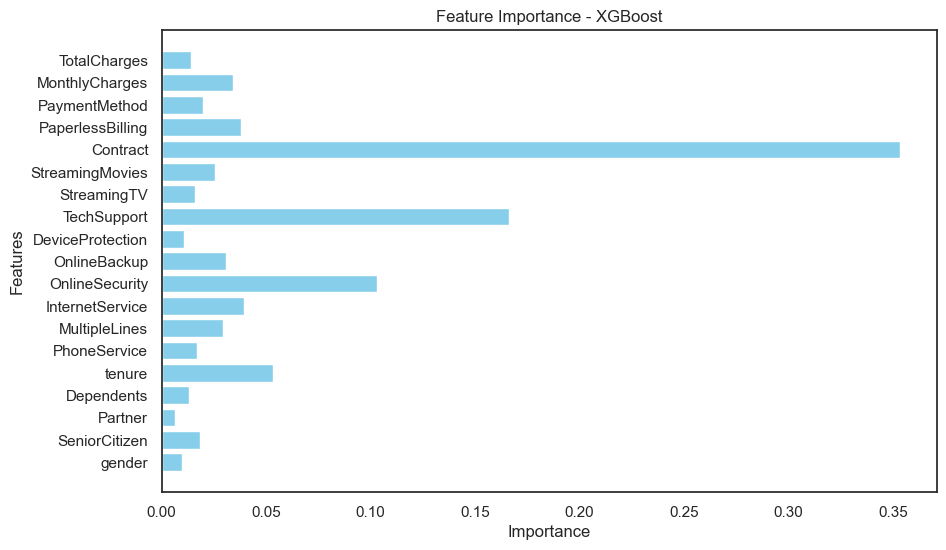

In [ ]:
importance = model.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(X.columns, importance, color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance - XGBoost")
plt.show()


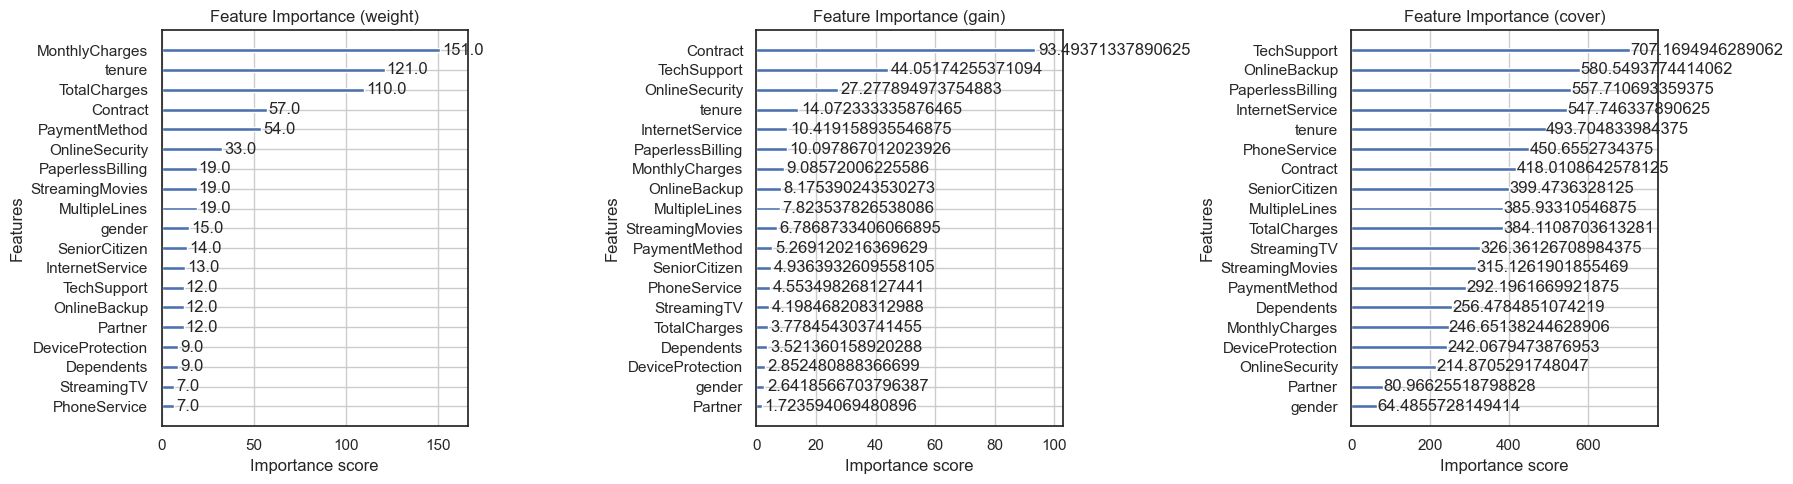

In [ ]:
importance_types = ['weight', 'gain', 'cover']

plt.figure(figsize=(18, 5))

for i, imp_type in enumerate(importance_types, 1):
    plt.subplot(1, 3, i)
    plot_importance(model, importance_type=imp_type, ax=plt.gca(), title=f"Feature Importance ({imp_type})")
    
plt.tight_layout()
plt.show()


In [ ]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_train)


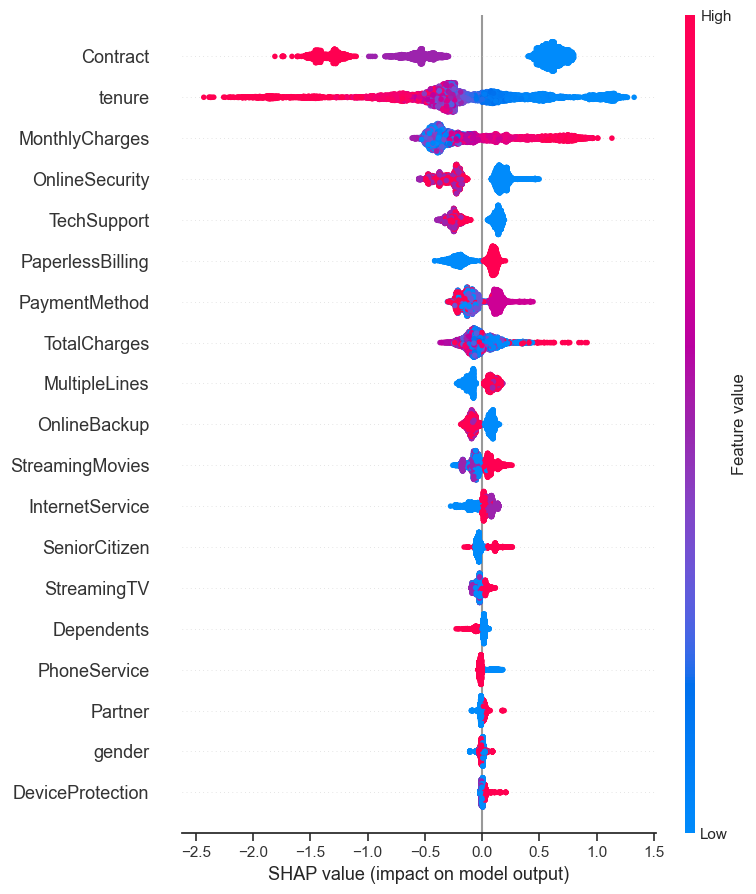

In [ ]:
shap.summary_plot(shap_values, X_train)


In [4]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
# Selected_feature = df.drop(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
#         'PhoneService', 'MultipleLines', 'InternetService',
#         'OnlineBackup', 'DeviceProtection', 'TechSupport',
#        'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
#        'PaymentMethod',  'TotalCharges', 'Churn'])

In [5]:
df_final.columns

Index(['customerID', 'SeniorCitizen', 'tenure', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'gender_Female', 'gender_Male', 'Partner_No',
       'Partner_Yes', 'Dependents_No', 'Dependents_Yes', 'PhoneService_No',
       'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
      

# One-hot encoder model

In [4]:
df_final["Churn"] = df_final["Churn"].map({"Yes": 1, "No": 0})
X = df_final.drop(columns=['customerID', 'Churn']) 
y = df_final["Churn"]  

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
model = LogisticRegression(random_state=42).fit(X_train, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train, y_train)}, test set {model.score(X_val, y_val)}")

Logistic regression: training set acc: 0.8042243521476748, test set 0.8218594748048261


c:\Users\korph\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
def model_automating_Hyperparamrter(trial, x_train, y_train, x_test, y_test):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)

    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy
    
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: model_automating_Hyperparamrter(trial, X_train, y_train, X_val, y_val), n_trials=500)

print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2025-09-22 22:09:00,384] A new study created in memory with name: no-name-2431540b-be8d-403b-81e1-a6923dcbe0f9
c:\Users\korph\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:09:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-09-22 22:09:00,762] Trial 0 finished with value: 0.7849538679914834 and parameters: {'n_estimators': 87, 'max_depth': 16, 'learning_rate': 0.08444663331962293}. Best is trial 0 with value: 0.7849538679914834.
c:\Users\korph\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:09:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-09-22 22:09:01,496] Trial 1 finished with value: 0.7771469127040455 and parameters: {'n_estimators': 218, 'max_depth': 17, 'learning_rate': 0.05332

Best parameters: {'n_estimators': 112, 'max_depth': 4, 'learning_rate': 0.05969562171419817}
Best accuracy: 0.8176011355571328


In [12]:
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.01,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)
print(f"XGBoost : training set acc: {model.score(X_train, y_train)}, test set {model.score(X_val, y_val)}")

XGBoost : training set acc: 0.8015619453319134, test set 0.7963094393186657


c:\Users\korph\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:37:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


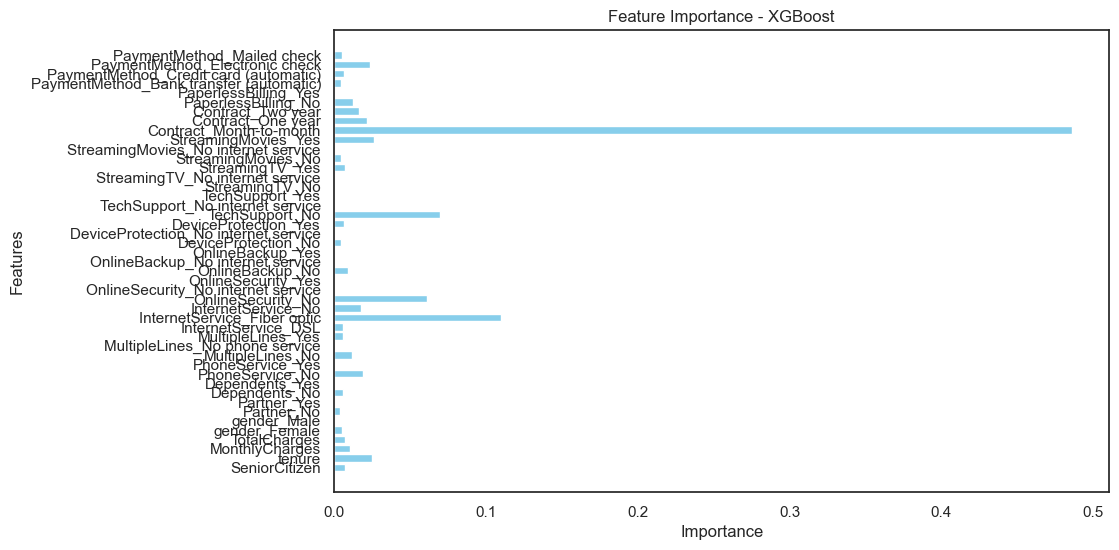

In [43]:
importance = model.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(X.columns, importance, color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance - XGBoost")
plt.show()


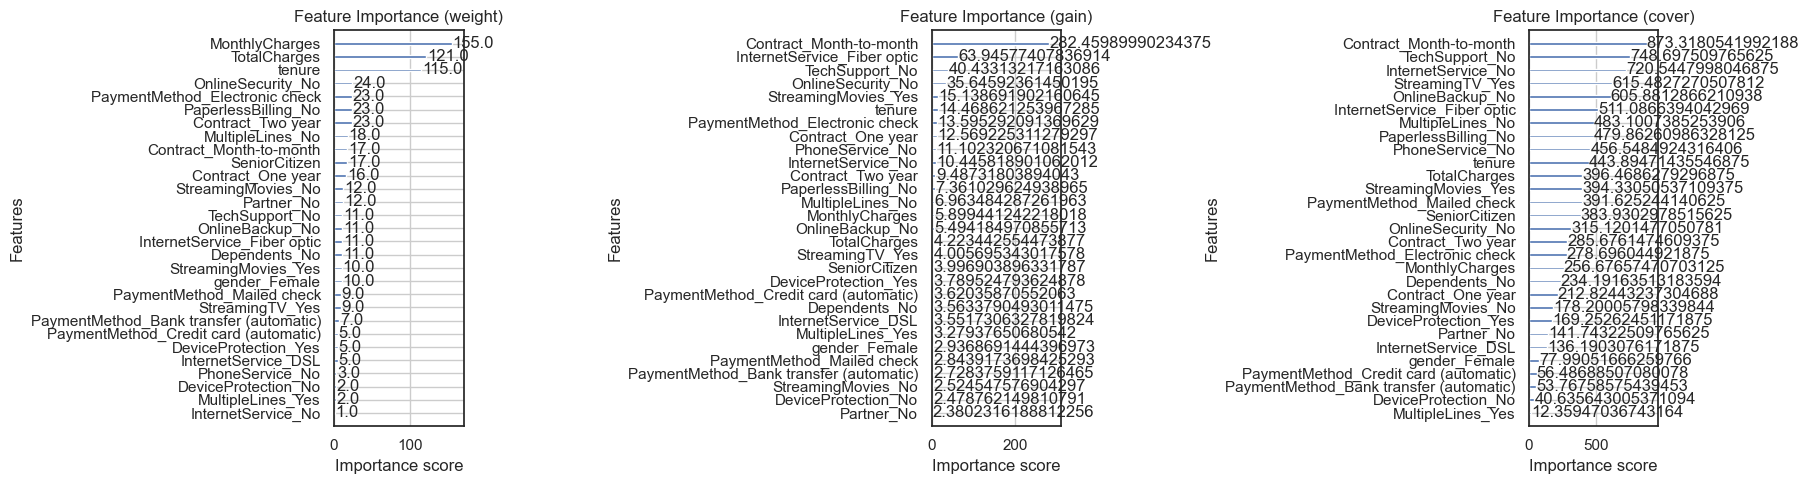

In [44]:
importance_types = ['weight', 'gain', 'cover']

plt.figure(figsize=(18, 5))

for i, imp_type in enumerate(importance_types, 1):
    plt.subplot(1, 3, i)
    plot_importance(model, importance_type=imp_type, ax=plt.gca(), title=f"Feature Importance ({imp_type})")
    
plt.tight_layout()
plt.show()


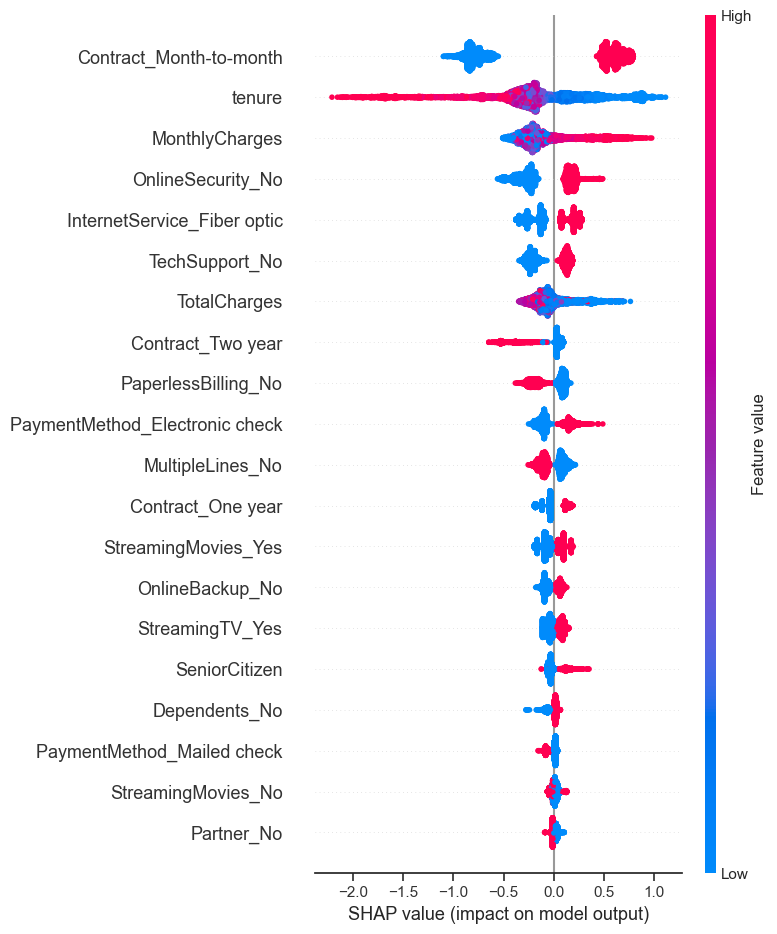

In [45]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)


# One-hot encoder with standard scaler

In [21]:
df_final["Churn"] = df_final["Churn"].map({"Yes": 1, "No": 0})
X = df_final.drop(columns=['customerID', 'Churn']) 
y = df_final["Churn"]  

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [23]:
model = LogisticRegression(random_state=42).fit(X_train_scaled, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train_scaled, y_train)}, test set {model.score(X_val_scaled, y_val)}")

Logistic regression: training set acc: 0.8031593894213702, test set 0.8204400283889283


In [24]:
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train_scaled, y_train)
print(f"XGBoost : training set acc: {model.score(X_train_scaled, y_train)}, test set {model.score(X_val_scaled, y_val)}")

XGBoost : training set acc: 0.8182463613773517, test set 0.8147622427253371


c:\Users\korph\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:17:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


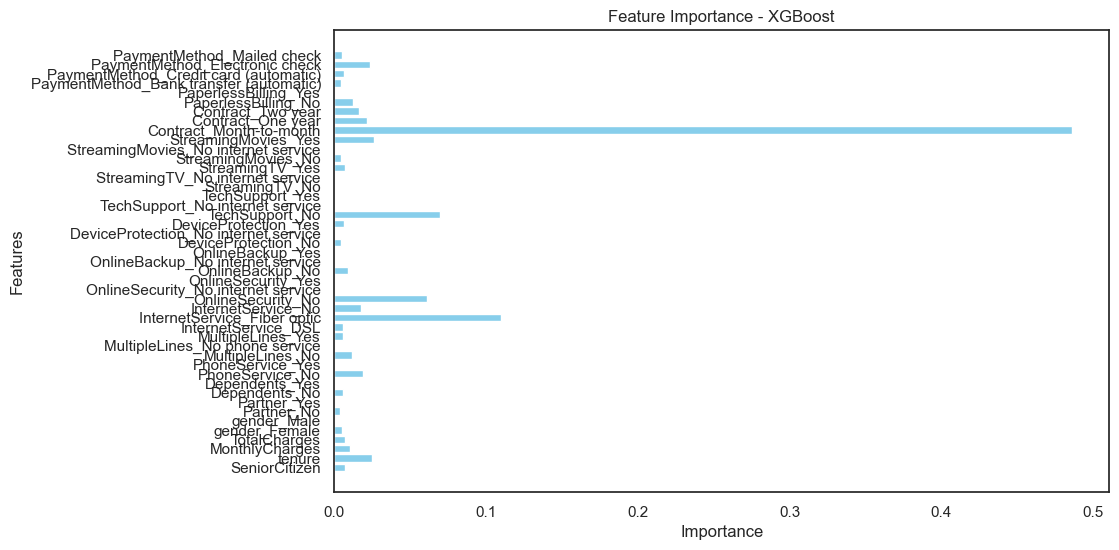

In [25]:
importance = model.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(X.columns, importance, color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance - XGBoost")
plt.show()


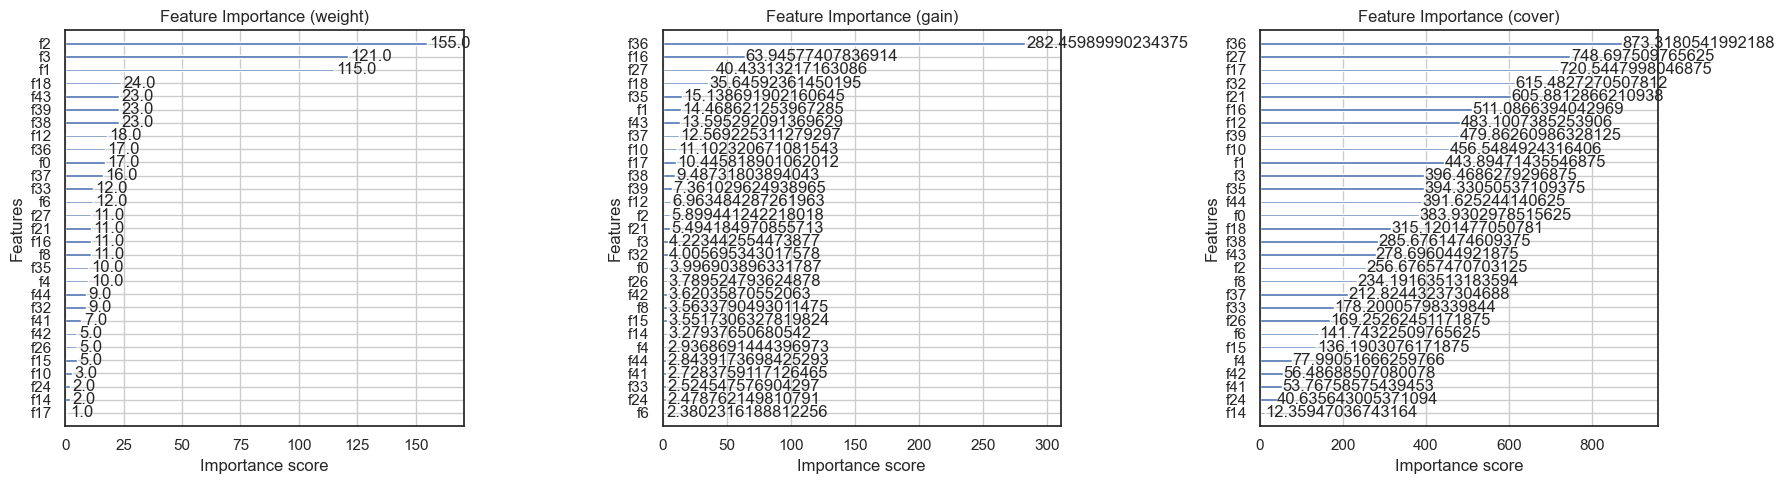

In [26]:
importance_types = ['weight', 'gain', 'cover']

plt.figure(figsize=(18, 5))

for i, imp_type in enumerate(importance_types, 1):
    plt.subplot(1, 3, i)
    plot_importance(model, importance_type=imp_type, ax=plt.gca(), title=f"Feature Importance ({imp_type})")
    
plt.tight_layout()
plt.show()


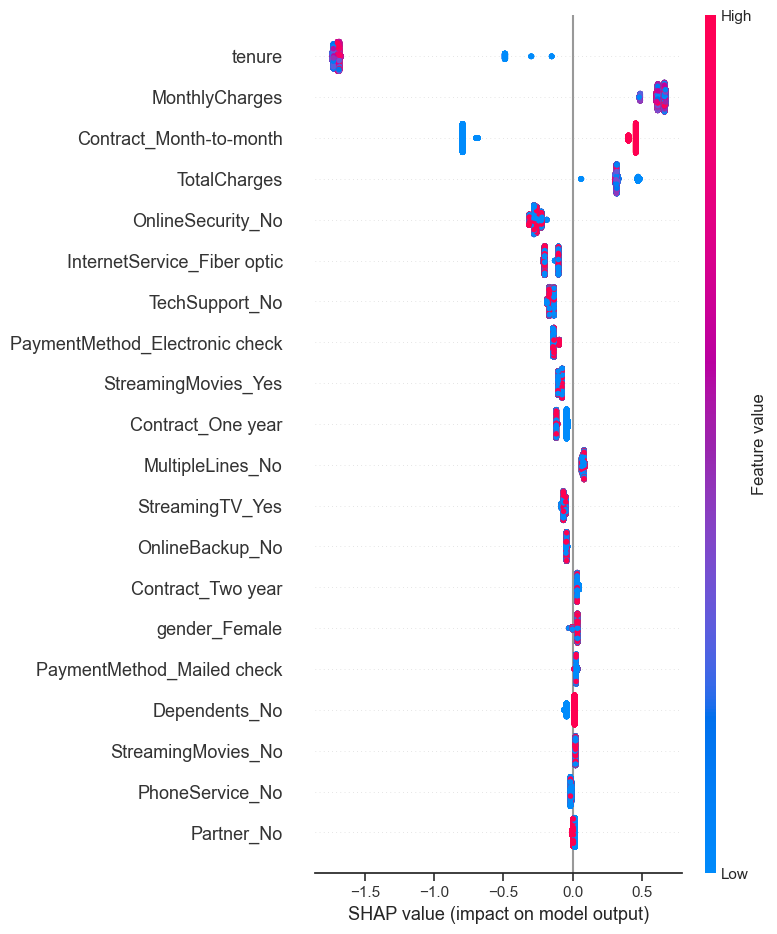

In [27]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)
